# GD_8. Seq2seq으로 번역기 만들기

## 0. IMPORT

In [29]:
! sudo apt -qq -y install fonts-nanum

fonts-nanum is already the newest version (20180306-3).
The following packages were automatically installed and are no longer required:
  accountsservice-ubuntu-schemas bc bluez-obexd cups cups-browsed cups-client
  cups-common cups-core-drivers cups-daemon cups-filters
  cups-filters-core-drivers cups-ipp-utils cups-ppdc cups-server-common
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript
  gir1.2-dbusmenu-glib-0.4 gnome-bluetooth gnome-power-manager
  gnome-screensaver gsettings-ubuntu-schemas gvfs-backends indicator-applet
  indicator-application indicator-appmenu indicator-bluetooth indicator-common
  indicator-datetime indicator-keyboard indicator-messages indicator-power
  indicator-printers indicator-session indicator-sound jayatana
  libaccounts-glib0 libbamf3-2 libcdio-cdda2 libcdio-paranoia2 libcdio18
  libcupsfilters1 libfcitx-config4 libfcitx-gclient1 libfcitx-utils0
  libfontembed1 libgnome-panel0 libgs9 libgs9-common libido3-0.1-0 libijs-0.35
  libindica

In [35]:
# sudo apt -qq -y install fonts-nanum - 터미널에서 한글 폰트 설치

import time
import re
import os
import io

from tqdm import tqdm    # tqdm
import random

import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from konlpy.tag import Mecab

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 

In [32]:
plt.rc('font', family='NanumGothic')
print(plt.rcParams['font.family'])

['NanumGothic']


## 1. Data

In [2]:
path_to_folder = os.getenv('HOME') + "/aiffel/s2s_translation/"
path_to_file_en =  path_to_folder + "korean-english-park.train.en"
path_to_file_ko = path_to_folder + "korean-english-park.train.ko"

In [3]:
with open(path_to_file_ko , "r") as f:
    data_ko = f.read().splitlines()

print("Data Size:", len(data_ko))
print("Example:")

for sen in data_ko[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [4]:
with open(path_to_file_en , "r") as f:
    data_en = f.read().splitlines()

print("Data Size:", len(data_en))
print("Example:")

for sen in data_en[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


## 2. Data Refine

In [5]:
cleaned_corpus = set(zip(data_ko,data_en))

In [6]:
def preprocess_sentence(sentence, k_token = False, e_token = False):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    if k_token:
        mecab = Mecab()
        sentence = re.sub(r"[^ㄱ-ㅎ|가-힣?.!,]+", " ", sentence)
        sentence = mecab.morphs(sentence)

    if e_token:
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
        sentence = sentence.strip()
        sentence = '<start> ' + sentence
        sentence += ' <end>'
        sentence = sentence.split()

    return sentence

In [7]:
eng_corpus = []
kor_corpus = []


for pair in cleaned_corpus:
    pre_kor = preprocess_sentence(pair[0], k_token = True)
    pre_eng = preprocess_sentence(pair[1], e_token = True)
    
    if (len(pre_kor) <= 40) & (len(pre_eng) <= 40): # 길이 40 이하의 토큰만 corpus에 추가 
        eng_corpus.append(pre_eng)
        kor_corpus.append(pre_kor)

In [8]:
print("English:", eng_corpus[40])  
print("Korean:", kor_corpus[40]) 

English: ['<start>', 'The', 'lawmakers', 'selection', ',', 'which', 'had', 'been', 'widely', 'expected', ',', 'came', 'five', 'days', 'after', 'Fidel', 'Castro', ',', ',', 'announced', 'his', 'resignation', 'in', 'a', 'letter', 'published', 'in', 'the', 'state', 'run', 'newspaper', 'Granma', '.', '<end>']
Korean: ['올해', '세인', '피델', '카스트로', '전', '쿠바', '국가', '평의회', '의장', '은', '이전', '국영', '일간', '그란', '마', '에', '서신', '을', '보내', '국가', '평의회', '의장', '직', '에서', '물러날', '뜻', '을', '공식', '적', '으로', '밝혔었', '다', '.']


In [9]:
print("English:", eng_corpus[80])  
print("Korean:", kor_corpus[80]) 

English: ['<start>', 'Korea', 's', 'consumer', 'confidence', 'plunged', 'to', 'its', 'lowest', 'in', 'four', 'years', 'in', 'November', ',', 'suggesting', 'that', 'domestic', 'demand', 'will', 'continue', 'to', 'be', 'a', 'big', 'drag', 'on', 'Asia', 's', 'third', 'largest', 'economy', '.', '<end>']
Korean: ['.', '소비자', '만족', '도', '년', '만', '에', '최하', '기록', '.']


In [10]:
print(len(kor_corpus), len(eng_corpus))

63139 63139


## 3. Tokenization

In [11]:
def tokenize(corpus, num_words = 15000):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = num_words, filters='')
    
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [12]:
# 토큰화하기

eng_tensor, eng_tokenizer = tokenize(eng_corpus)
kor_tensor, kor_tokenizer = tokenize(kor_corpus)

In [13]:
del eng_corpus
del kor_corpus
del cleaned_corpus

In [14]:
print("English Vocab Size:", len(eng_tokenizer.index_word))
print("Korean Vocab Size:", len(kor_tokenizer.index_word))

English Vocab Size: 38540
Korean Vocab Size: 37075


In [15]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [16]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [17]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [18]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(kor_tokenizer.index_word) + 1 # 예: len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(eng_tokenizer.index_word) + 1 # 예: len(dec_tokenizer.index_word) + 1

units         = 512
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 512)
Decoder Output: (64, 38541)
Decoder Hidden State: (64, 512)
Attention: (64, 40, 1)


In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [20]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

## 4. Model Train

In [21]:
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_tensor[idx:idx+BATCH_SIZE],
                                eng_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 987/987 [04:30<00:00,  3.65it/s, Loss 1.8156]


In [22]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_tensor.shape[-1], kor_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence, k_token= True)
    inputs = kor_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=kor_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(eng_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += eng_tokenizer.index_word[predicted_id] + ' '

        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

In [23]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [24]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is the president . <end> 


/tmp/ipykernel_165/421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_165/421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


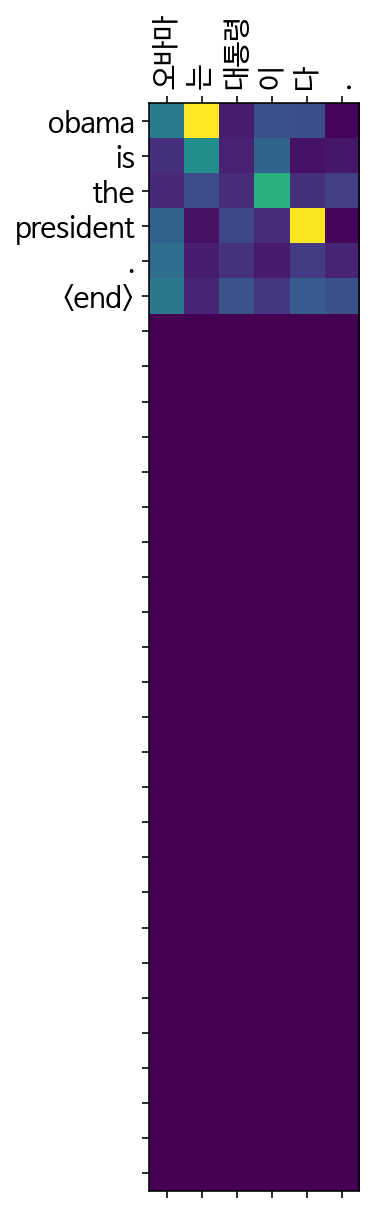

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: they have been a crime in the city of the city of the city of the city of the city of the city of the city of the city of the city of the city of the city of the 


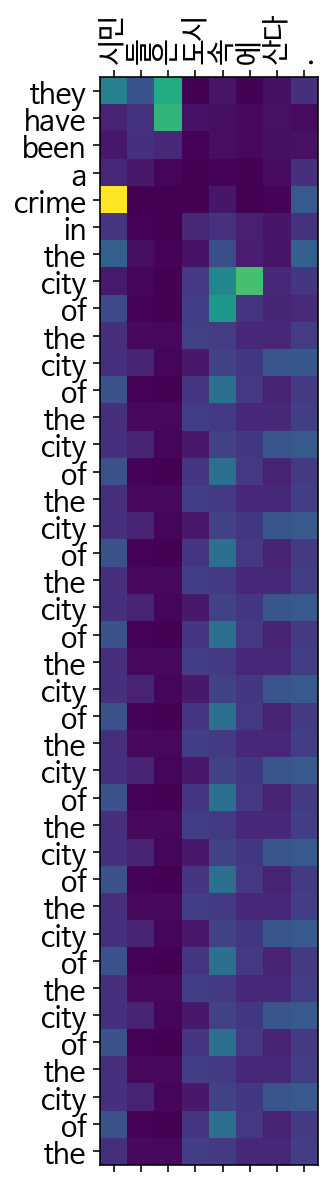

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: if you re not going to be . <end> 


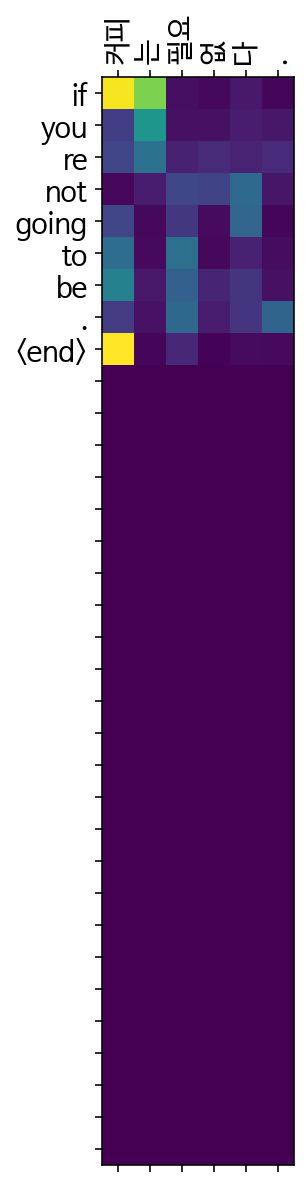

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the dead were killed . <end> 


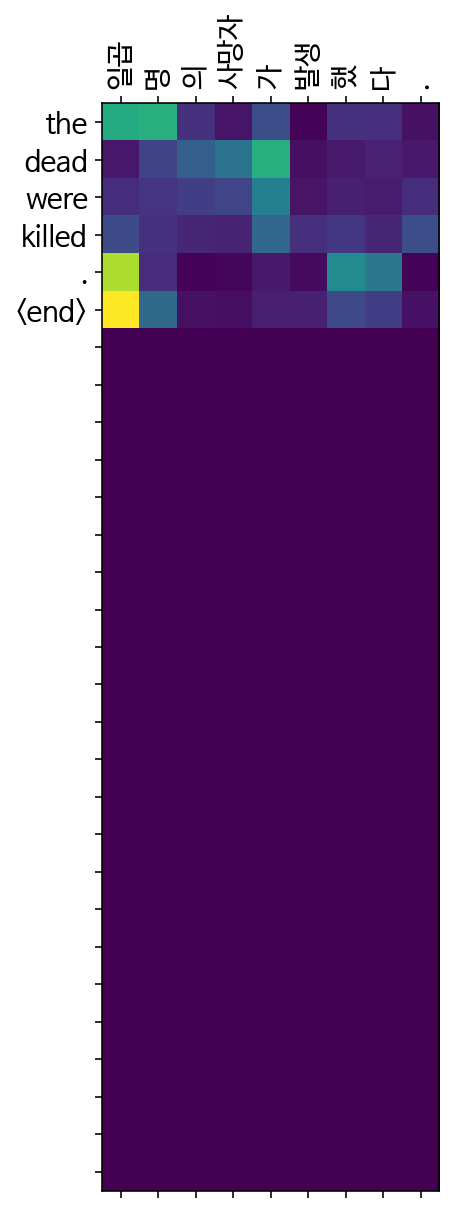

In [37]:
translate("오바마는 대통령이다.", encoder, decoder)
translate("시민들은 도시 속에 산다.", encoder, decoder)
translate("커피는 필요 없다.", encoder, decoder)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

## 5. Retrospection

- "시민들은 도시 속에 산다." 를 보면 중간에 <end> 가 나오지 않아서 계속 반복이 됩니다.  
제 생각에는 중간에 코드를 잘 못 만진 것 같은데 아마 토큰화에서 실수를 한 것 같습니다.  

     
- 다른 교육생 분과 비교했을 때 에포크 돌리는 사이즈가 달랐습니다.  
    배치사이즈도 같았지만 왜 다른지에 대해서는 조금더 생각이 필요할 것 같습니다.